<a href="https://colab.research.google.com/github/KarimaAL/mono_depth_estimator/blob/master/last_essai_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import imageio
import numpy as np
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import cv2
import shutil
#tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
class Helpers():
    
    @staticmethod
    def normalize(images):
        return np.array(images)/127.5-1.0
    
    @staticmethod
    def unnormalize(images):
        return (0.5*np.array(images)+0.5)*255
    
    @staticmethod
    def resize(image, size):
        return np.array(cv2.resize(image, size))
    
    @staticmethod
    def split_images(image, is_testing):
        image = imageio.imread(image).astype(np.float)
        _, width, _ = image.shape
        half_width = int(width/2)
        source_image = image[:, half_width:, :]
        destination_image = image[:, :half_width, :]
        source_image = Helpers.resize(source_image, (IMAGE_SIZE, IMAGE_SIZE))
        destination_image = Helpers.resize(destination_image, (IMAGE_SIZE, IMAGE_SIZE))
        if not is_testing and np.random.random() > 0.5:
            source_image = np.fliplr(source_image)
            destination_image = np.fliplr(destination_image)
        return source_image, destination_image
    
    @staticmethod
    def new_dir(path):
        shutil.rmtree(path, ignore_errors=True)
        os.makedirs(path, exist_ok=True)
        
    @staticmethod
    def archive_output():
        shutil.make_archive("output", "zip", "./output")
        
    @staticmethod
    def image_pairs(batch, is_testing):
        source_images, destination_images = [], []
        for image_path in batch:
            source_image, destination_image = Helpers.split_images(image_path, is_testing)
            source_images.append(source_image)
            destination_images.append(destination_image)
        return source_images, destination_images

In [0]:
# Requires following dataset structure:
# dataset_name
# └── dataset_name
#     ├── testing
#     │   └── ... (image files)
#     ├── testing_raw
#     │   ├── ... (image files)
#     ├── training
#     │   └── ... (image files)
#     └── validation (optional)
#         └── ... (image files)
class DataLoader():
    
    def __init__(self, dataset_name="pix2pix-depth"):
        self.dataset_name = dataset_name
        base_path = BASE_INPUT_PATH + self.dataset_name + "/" + self.dataset_name + "/"
        self.training_path = base_path + "training/"
        self.validation_path = base_path + "validation/"
        self.testing_path = base_path + "testing/"
        self.testing_raw_path = base_path + "testing_raw/"

    def load_random_data(self, data_size, is_testing=False):
        paths = glob(self.training_path+"*") if is_testing else glob(self.testing_path+"*")
        source_images, destination_images = Helpers.image_pairs(np.random.choice(paths, size=data_size), is_testing)
        return Helpers.normalize(source_images), Helpers.normalize(destination_images)

    def yield_batch(self, batch_size, is_testing=False):
        paths = glob(self.training_path+"*") if is_testing else glob(self.validation_path+"*")
        for i in range(int(len(paths)/batch_size)-1):
            batch = paths[i*batch_size:(i+1)*batch_size]
            source_images, destination_images = Helpers.image_pairs(batch, is_testing)
            yield Helpers.normalize(source_images), Helpers.normalize(destination_images)

In [0]:
# Model architecture from: https://phillipi.github.io/pix2pix/
class Pix2Pix(): 
    
    def __init__(self):
        Helpers.new_dir(BASE_OUTPUT_PATH + "training/")
        Helpers.new_dir(BASE_OUTPUT_PATH + "training/losses/")

        self.image_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)
        self.data_loader = DataLoader()

        patch = int(IMAGE_SIZE / 2**4)
        self.disc_patch = (patch, patch, 1)

        self.generator_filters = 64
        self.discriminator_filters = 64
        
        optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, BETA_1)

        self.discriminator = self.discriminator()
        self.discriminator.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])
        self.generator = self.generator()

        source_image = tf.keras.layers.Input(shape=self.image_shape)
        destination_image = tf.keras.layers.Input(shape=self.image_shape)
        generated_image = self.generator(destination_image)

        self.discriminator.trainable = False
        valid = self.discriminator([generated_image, destination_image])
        self.combined = tf.keras.models.Model(inputs=[source_image, destination_image], outputs=[valid, generated_image])
        self.combined.compile(loss=["mse", "mae"], loss_weights=[1, 100], optimizer=optimizer)

    def generator(self):
        def conv2d(layer_input, filters, bn=True):
            downsample = tf.keras.layers.Conv2D(filters, kernel_size=4, strides=2, padding="same")(layer_input)
            downsample = tf.keras.layers.LeakyReLU(alpha=LEAKY_RELU_ALPHA)(downsample)
            if bn:
                downsample = tf.keras.layers.BatchNormalization(momentum=BN_MOMENTUM)(downsample)
            return downsample

        def deconv2d(layer_input, skip_input, filters, dropout_rate=0):
            upsample = tf.keras.layers.UpSampling2D(size=2)(layer_input)
            upsample = tf.keras.layers.Conv2D(filters, kernel_size=4, strides=1, padding="same", activation="relu")(upsample)
            if dropout_rate:
                upsample = tf.keras.layers.Dropout(dropout_rate)(upsample)
            upsample = tf.keras.layers.BatchNormalization(momentum=BN_MOMENTUM)(upsample)
            upsample = tf.keras.layers.Concatenate()([upsample, skip_input])
            return upsample

        downsample_0 = tf.keras.layers.Input(shape=self.image_shape)
        downsample_1 = conv2d(downsample_0, self.generator_filters, bn=False)
        downsample_2 = conv2d(downsample_1, self.generator_filters*2)
        downsample_3 = conv2d(downsample_2, self.generator_filters*4)
        downsample_4 = conv2d(downsample_3, self.generator_filters*8)
        downsample_5 = conv2d(downsample_4, self.generator_filters*8)
        downsample_6 = conv2d(downsample_5, self.generator_filters*8)
        downsample_7 = conv2d(downsample_6, self.generator_filters*8)

        upsample_1 = deconv2d(downsample_7, downsample_6, self.generator_filters*8)
        upsample_2 = deconv2d(upsample_1, downsample_5, self.generator_filters*8)
        upsample_3 = deconv2d(upsample_2, downsample_4, self.generator_filters*8)
        upsample_4 = deconv2d(upsample_3, downsample_3, self.generator_filters*4)
        upsample_5 = deconv2d(upsample_4, downsample_2, self.generator_filters*2)
        upsample_6 = deconv2d(upsample_5, downsample_1, self.generator_filters)
        upsample_7 = tf.keras.layers.UpSampling2D(size=2)(upsample_6)
        
        output_image = tf.keras.layers.Conv2D(IMAGE_CHANNELS, kernel_size=4, strides=1, padding="same", activation="tanh")(upsample_7)
        return tf.keras.models.Model(downsample_0, output_image)

    def discriminator(self):
        def discriminator_layer(layer_input, filters, bn=True):
            discriminator_layer = tf.keras.layers.Conv2D(filters, kernel_size=4, strides=2, padding="same")(layer_input)
            discriminator_layer = tf.keras.layers.LeakyReLU(alpha=LEAKY_RELU_ALPHA)(discriminator_layer)
            if bn:
                discriminator_layer = tf.keras.layers.BatchNormalization(momentum=BN_MOMENTUM)(discriminator_layer)
            return discriminator_layer

        source_image = tf.keras.layers.Input(shape=self.image_shape)
        destination_image = tf.keras.layers.Input(shape=self.image_shape)
        combined_images = tf.keras.layers.Concatenate(axis=-1)([source_image, destination_image])
        discriminator_layer_1 = discriminator_layer(combined_images, self.discriminator_filters, bn=False)
        discriminator_layer_2 = discriminator_layer(discriminator_layer_1, self.discriminator_filters*2)
        discriminator_layer_3 = discriminator_layer(discriminator_layer_2, self.discriminator_filters*4)
        discriminator_layer_4 = discriminator_layer(discriminator_layer_3, self.discriminator_filters*8)
        validity = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding="same")(discriminator_layer_4)
        return tf.keras.models.Model([source_image, destination_image], validity)
        
    def preview_training_progress(self, epoch, size=3):
        def preview_outputs(epoch, size):
            source_images, destination_images = self.data_loader.load_random_data(size, is_testing=True)
            generated_images = self.generator.predict(destination_images)
            grid_image = None
            for i in range(size):
                row = Helpers.unnormalize(np.concatenate([destination_images[i], generated_images[i], source_images[i]], axis=1))
                if grid_image is None:
                    grid_image = row
                else:
                    grid_image = np.concatenate([grid_image, row], axis=0)
            plt.imshow(grid_image/255.0)
            plt.show()
            plt.close()
            grid_image = cv2.cvtColor(np.float32(grid_image), cv2.COLOR_RGB2BGR)
            cv2.imwrite(BASE_OUTPUT_PATH + "training/ " + str(epoch) + ".png", grid_image)
            
        def preview_losses():
            def plot(title, data):
                plt.plot(data, alpha=0.6)
                plt.title(title + "_" + str(i))
                plt.savefig(BASE_OUTPUT_PATH + "training/losses/" + title + "_" + str(i) + ".png")
                plt.close()
            for i, d in enumerate(self.d_losses):
                plot("discriminator", d)
            for i, g in enumerate(self.g_losses):
                plot("generator", g)
                
        preview_outputs(epoch, size)
        preview_losses()

    def train(self):
        valid = np.ones((BATCH_SIZE,) + self.disc_patch)
        fake = np.zeros((BATCH_SIZE,) + self.disc_patch)
        self.d_losses = []
        self.g_losses = []
        self.preview_training_progress(0)
        for epoch in range(EPOCHS):
            epoch_d_losses = []
            epoch_g_losses = []
            for iteration, (source_images, destination_images) in enumerate(self.data_loader.yield_batch(BATCH_SIZE)):
                generated_images = self.generator.predict(destination_images)
                d_loss_real = self.discriminator.train_on_batch([source_images, destination_images], valid)
                d_loss_fake = self.discriminator.train_on_batch([generated_images, destination_images], fake)
                d_losses = 0.5 * np.add(d_loss_real, d_loss_fake)
                g_losses = self.combined.train_on_batch([source_images, destination_images], [valid, source_images])
                epoch_d_losses.append(d_losses)
                epoch_g_losses.append(g_losses)
                print("\repoch: " + str(epoch) 
                      +", iteration: "+ str(iteration) 
                      + ", d_losses: " + str(d_losses) 
                      + ", g_losses: " + str(g_losses)
                      , sep=" ", end=" ", flush=True)
            self.d_losses.append(np.average(epoch_d_losses, axis=0))
            self.g_losses.append(np.average(epoch_g_losses, axis=0))
            self.preview_training_progress(epoch)
        
    def test(self):
        image_paths = glob(self.data_loader.testing_raw_path+"*")
        for image_path in image_paths:
            image = np.array(imageio.imread(image_path))
            image_normalized = Helpers.normalize(image)
            generated_batch = self.generator.predict(np.array([image_normalized]))
            concat = Helpers.unnormalize(np.concatenate([image_normalized, generated_batch[0]], axis=1))
            cv2.imwrite(BASE_OUTPUT_PATH+os.path.basename(image_path), cv2.cvtColor(np.float32(concat), cv2.COLOR_RGB2BGR))

In [0]:
 ! pip install -q kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aliouakarima","key":"3924c490eca1bfe7b62277a1faf84eab"}'}

In [0]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
! kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)    1GB  2020-04-17 22:02:37          53881  
roche-data-science-coalition/uncover                           UNCOVER COVID-19 Challenge                          123MB  2020-04-08 22:04:30           4288  
praveengovi/coronahack-chest-xraydataset                       CoronaHack -Chest X-Ray-Dataset                       1GB  2020-03-20 01:26:40            768  
katerpillar/meteonet                                           MeteoNet North-West France                           11GB  2020-04-16 08:35:45             57  
andrewmvd/covid19-ct-scans                    

In [0]:
!kaggle datasets list -s 'Pix2Pix Depth Images'

ref                                title                      size  lastUpdated          downloadCount  
---------------------------------  ------------------------  -----  -------------------  -------------  
greg115/pix2pix-depth              Pix2Pix Depth Images        1GB  2019-10-01 08:17:01             58  
vikramtiwari/pix2pix-dataset       pix2pix dataset             2GB  2018-07-04 05:54:59           1260  
dansbecker/cityscapes-image-pairs  Cityscapes Image Pairs    202MB  2018-04-20 13:55:20           1883  
4quant/eye-gaze                    Eye Gaze                    4GB  2018-06-27 07:15:30           3289  
xxc025/building-photos             Building_photos           187MB  2019-03-28 06:29:06             55  
elibooklover/victorian400          Victorian400              489MB  2019-12-05 01:21:37             27  
kmader/eye-oct-datasets            Eye OCT Datasets          551MB  2018-03-22 15:58:22           1000  
flhonker/pbug-pose-imtate-pix2pix  pbug_pose_imtate_pix

In [0]:
!kaggle datasets download -d greg115/pix2pix-depth

100% 1.41G/1.41G [00:11<00:00, 137MB/s]



In [0]:
! mkdir data

In [0]:
! unzip pix2pix-depth.zip -d data

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/pix2pix-depth/pix2pix-depth/training/24214844.png  
  inflating: data/pix2pix-depth/pix2pix-depth/training/24224845.png  
  inflating: data/pix2pix-depth/pix2pix-depth/training/24224846.png  
  inflating: data/pix2pix-depth/pix2pix-depth/training/24234847.png  
  inflating: data/pix2pix-depth/pix2pix-depth/training/24234848.png  
  inflating: data/pix2pix-depth/pix2pix-depth/training/24244849.png  
  inflating: data/pix2pix-depth/pix2pix-depth/training/24244850.png  
  inflating: data/pix2pix-depth/pix2pix-depth/training/242485.png  
  inflating: data/pix2pix-depth/pix2pix-depth/training/242486.png  
  inflating: data/pix2pix-depth/pix2pix-depth/training/24264853.png  
  inflating: data/pix2pix-depth/pix2pix-depth/training/24264854.png  
  inflating: data/pix2pix-depth/pix2pix-depth/training/24274855.png  
  inflating: data/pix2pix-depth/pix2pix-depth/training/24274856.png  
  inflating: dat

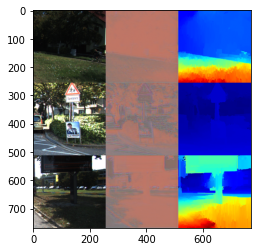

epoch: 0, iteration: 0, d_losses: [12.68532717  0.44085693], g_losses: [94.13351440429688, 1.1740424633026123, 0.9295947551727295] 

In [0]:
BASE_INPUT_PATH = "/content/data/" 
BASE_OUTPUT_PATH = "./output/"

IMAGE_SIZE = 256
IMAGE_CHANNELS = 3
LEARNING_RATE = 0.00015
BETA_1 = 0.5
LEAKY_RELU_ALPHA = 0.2
BN_MOMENTUM = 0.8
EPOCHS = 50
BATCH_SIZE = 32

gan = Pix2Pix()
gan.train()
gan.test()
Helpers.archive_output()

In [0]:
gan.generator.save('/content/drive/My Drive/data/model1.h5')
gan.generator.save('model1.h5')

In [0]:
! mkdir out
! unzip output.zip -d out

unzip:  cannot find or open output.zip, output.zip.zip or output.zip.ZIP.


In [0]:
from matplotlib import pyplot as plt
import cv2

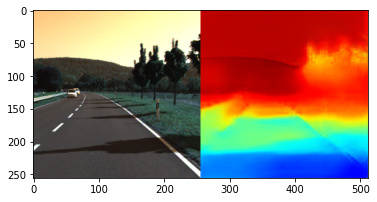

In [0]:
a=cv2.imread('/content/output/0.png')
plt.imshow(a)
plt.show()

In [0]:
gan = Pix2Pix()
gan.generator.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 128, 128, 64) 3136        input_8[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 128, 128, 64) 0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 64, 64, 128)  131200      leaky_re_lu_15[0][0]             
____________________________________________________________________________________________

In [0]:
gan = Pix2Pix()
gan.generator.save('model.h5')

In [0]:
new_model = tf.keras.models.load_model('model1.h5',compile=False)

In [0]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_4[0][0]              
____________________________________________________________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show>

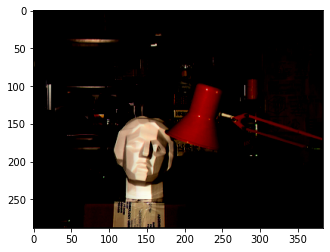

In [0]:
image_path = ('/content/1.png')
image = np.array(imageio.imread(image_path))
image_normalized = Helpers.normalize(image)
plt.imshow(image)
plt.show
plt.imshow(image_normalized)
plt.show

In [0]:
print(image_normalized.shape)

(288, 384, 3)


In [0]:
img = cv2.resize(image_normalized,(256,256))
print(img.shape)

(256, 256, 3)


In [0]:
#img =(np.expand_dims(img,axis=0))
img = tf.cast(img, tf.float32)
print(img.shape)

(256, 256, 3)


In [0]:
generated_batch = new_model.predict(np.array([img]))
# concat = Helpers.unnormalize(np.concatenate([image_normalized, generated_batch[0]], axis=1))
# cv2.imwrite(BASE_OUTPUT_PATH+os.path.basename(image_path), cv2.cvtColor(np.float32(concat), cv2.COLOR_RGB2BGR))

In [0]:
concat = Helpers.unnormalize(np.concatenate([img, generated_batch[0]], axis=1))

In [0]:
cv2.imwrite('/content/saved/result2.png', cv2.cvtColor(np.float32(concat), cv2.COLOR_RGB2BGR))


True

<function matplotlib.pyplot.show>

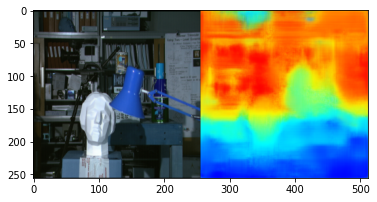

In [0]:
imageTest=cv2.imread('/content/saved/result2.png')
plt.imshow(imageTest)
plt.show